In [1]:
include("../../datatools.jl")
using LinearAlgebra, Plots, CSV, DataFrames, Optim, DataStructures, Statistics, Polynomials, LaTeXStrings

In [2]:
all_dfs = get_all_dataframes();


foreach(println, names(all_dfs["Gale/East"][1]))

time
seconds_elapsed
bearingAccuracy
speedAccuracy
verticalAccuracy
horizontalAccuracy
speed
bearing
altitude
longitude
latitude


In [3]:
df = stack_all_streets(all_dfs);


In [4]:
#Gale/East DataFrame
gedf = stack_df_vectors(all_dfs["Gale/East"])

2358×12 DataFrame
  Row │ time                 seconds_elapsed  bearingAccuracy  speedAccuracy   ⋯
      │ Int64                Float64          Float64          Float64         ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1712673345957308200          2.23231          56.2089       1.93259    ⋯
    2 │ 1712673346953398500          3.2284           37.5656       1.85054
    3 │ 1712673347951245800          4.22625          29.1882       3.3669
    4 │ 1712673348949596700          5.2246           48.6896       2.6411
    5 │ 1712673349951116800          6.22612          69.3095       2.68419    ⋯
    6 │ 1712673350959734000          7.23473          58.7006       1.45248
    7 │ 1712673351959546400          8.23455          28.5719       1.7184
    8 │ 1712673352957081000          9.23208          26.3722       0.851469
  ⋮   │          ⋮                  ⋮                ⋮               ⋮         ⋱
 2352 │ 1712267956367289600        339.659            45.0          0.195318   ⋯
 2353 │ 1712267956684755200        339.977            45.0          0.249485
 2354 │ 1712267957283247400        340.575            45.0          0.220985
 2355 │ 1712267957367800600        340.66             45.0          0.19803
 2356 │ 1712267957824489500        341.116            45.0          0.247157   ⋯
 2357 │ 1712267958367968500        341.66             45.0          0.201234
 2358 │ 1712267958424023800        341.716            45.0          0.201234
                                                 8 columns and 2343 rows omitted

In [6]:
function fit_model_to_data(xs, ys, model_func, initial_params; n=100)

     # make sure input coordinates are scaled !!

     train_xs, train_ys = get_spaced_nodes(xs, ys, n)

     function loss(params)
          predicted_y = model_func(train_xs, params...)
          return sum((train_ys - predicted_y).^2)
     end

     opt_res = optimize(loss, initial_params)
     opt_params = Optim.minimizer(opt_res)

     fitted_ys = model_func(xs, opt_params)

     temp = DataFrame(latitude=xs, altitude=fitted_ys)
     sort!(temp, :altitude)

     return temp

end

fit_model_to_data (generic function with 1 method)

In [7]:
# test functions

function gompertz(x, a, b, c, d)
     e = exp(1)
     return @. (a * e^(b*e^(-c*x)) + d)
end

function expo(xs, a, b, c)
     return  @. a * exp(b * xs) + c 
end

function sigmoid(x, a, b, c)
     res = @. c / (1.0 + exp(-a * (x-b)))
     return res
end

sigmoid (generic function with 1 method)

In [8]:
function ridge_regression_expo(xs, ys, test_x, λ)
     
     # taking log(y) requires y>0

     offset = abs(minimum(ys)) + 1.0

     Y = log.(ys .+ offset)

     # design matrix
     X = hcat(ones(length(xs)), xs)

     # regularization matrix
     L = λ * I(size(X, 2))
     L[1, 1] = 0

     # ridge reg. 
     θ = (X' * X + L) \ (X' * Y)

     # Predict on new data
     ln_y_pred = @. θ[1] + θ[2] .* test_x

     y_pred = exp.(ln_y_pred) .- offset 

     # package up into easy to use form 
     temp = DataFrame(latitude=test_x, altitude=y_pred)
     sort!(temp, :latitude)

     return temp

end

ridge_regression_expo (generic function with 1 method)

In [9]:
function find_best_lambdas(ridge_function, ridge_params, ys; eval_size=1000, num_lambdas=5, step_size=1)
     results = []
     n=eval_size

     for i = 0:step_size:n
          ft = ridge_function(ridge_params..., float(i))
          x = ft.latitude
          y = ft.altitude

          diff = sqrt(mean((ys - y) .^2))

          push!(results, (lambda=float(i), rmse=diff))
     end

     best = nsmallest(num_lambdas, results, by=x->x.rmse)

     return best

end

find_best_lambdas (generic function with 1 method)

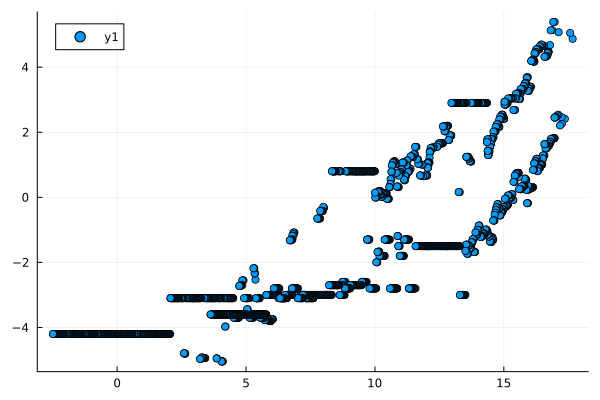

In [10]:
scaled_gedf = scale_coordinates(gedf)

xs = scaled_gedf.latitude;
ys = scaled_gedf.altitude;

scatter(xs, ys)

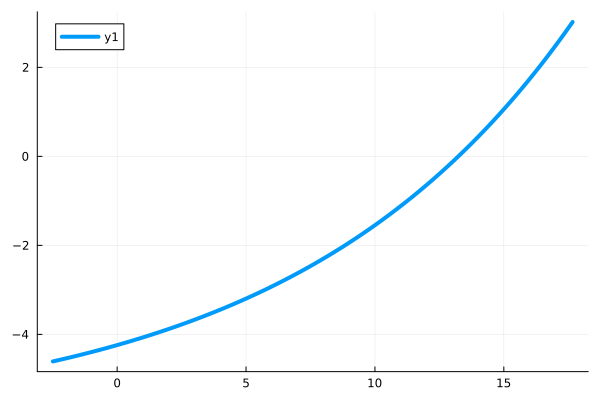

In [11]:
test_x = collect(range(minimum(xs), maximum(xs), length(xs)));

ft = ridge_regression_expo(xs, ys, test_x, 1.0)

# scatter(xs, ys)
plot(ft.latitude, ft.altitude, lw=4)

In [12]:
find_best_lambdas(ridge_regression_expo, [xs, ys, test_x], ys; eval_size=100)

5-element Vector{Any}:
 (lambda = 100.0, rmse = 3.9792712901091245)
 (lambda = 99.0, rmse = 3.979300347955401)
 (lambda = 98.0, rmse = 3.979329407030736)
 (lambda = 97.0, rmse = 3.9793584673352087)
 (lambda = 96.0, rmse = 3.9793875288689002)

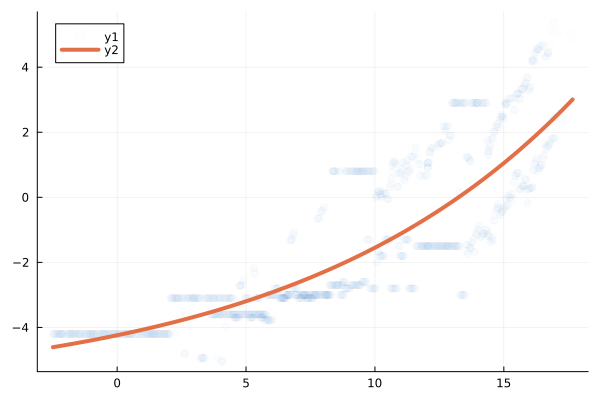

In [13]:
ft = ridge_regression_expo(xs, ys, test_x, 100.)
scatter(xs, ys, ma=0.01)
plot!(ft.latitude, ft.altitude, lw=4)


$y = ae^{kx}$

$ln(y) = ln(a) + kx$

look at the objective instead of rmse

||y -Xc|| - \lambda ||c||2

Fix lam, optim c
Fix c, optim lam

In [15]:
xs = collect(0:0.5:20)
ys = tanh.(xs) + randn(length(xs)) / 25

f(x) = exp.(x)
g(x) = tanh.(x)

res(x, a, b, c) = @. a + b*f(x) + c*g(x)


M = hcat(ones(length(xs)), f.(xs), g.(xs))

results = []

for i in 1:size(M, 2)
     A = M[:, i]
     X = A \ ys
     push!(results, X)
end

results

3-element Vector{Any}:
 0.943785384113408
 3.325396934847706e-9
 0.9896000320104156

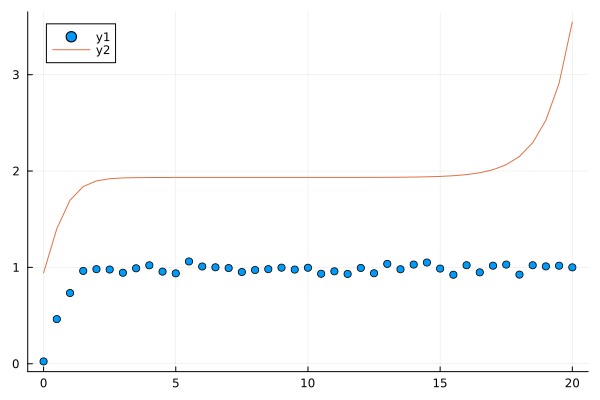

In [16]:
scatter(xs, ys)
plot!(xs, res(xs, results...))

In [17]:
function linear_combo_result(xs, basis_functions, results)

     intercept = results[1]
     coefficients = results[2:end]

     ys = sum((coefficients[i] .* basis_functions[i](xs)) for i in 1:length(basis_functions))

     return ys .+ intercept

end

linear_combo_result (generic function with 1 method)

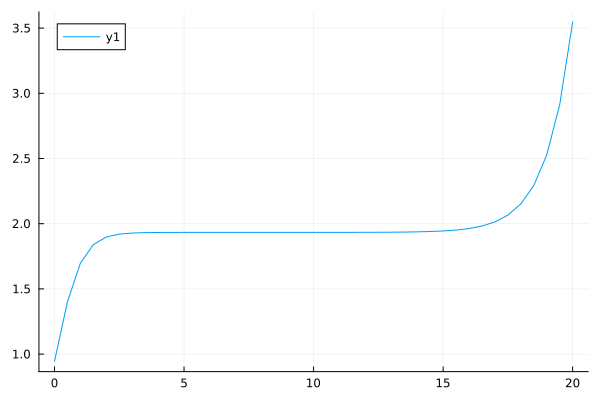

In [18]:
ys = linear_combo_result(xs, [f, g], results)



plot(xs, ys)

In [55]:
function linear_ls(xs, ys, model_funcs)

     design_cols = [model_funcs[i](xs) for i in 1:length(model_funcs)]

     M = hcat(ones(length(xs)), design_cols...)

     X = M \ ys

     results = X

     intercept = results[1]
     coefficients = results[2:end]

     fit_ys = intercept .+ sum((coefficients[i] * model_funcs[i](xs)) 
                              for i in 1:length(model_funcs))

     ft = DataFrame(latitude=xs, altitude=fit_ys, residuals=(ys - fit_ys))
     sort!(ft, :latitude)

     return ft
end

linear_ls (generic function with 1 method)

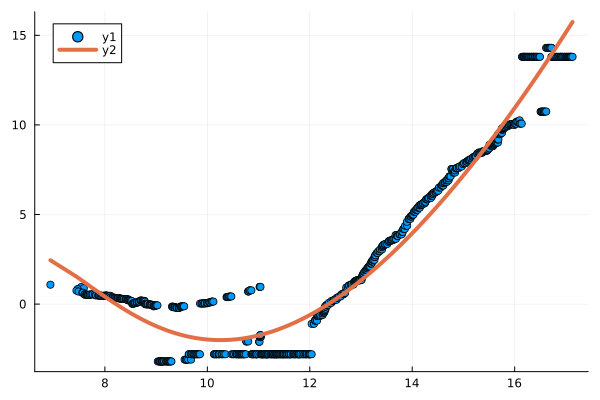

In [127]:
gedf = scale_coordinates(stack_df_vectors(all_dfs["Newell/West"]))

xs = gedf.latitude
ys = gedf.altitude

# xs = collect(0:0.5:20)
# ys = sin.(xs) + tanh.(xs) + randn(length(xs))/20



f(x) = tanh.(x) 
g(x) = x
h(x) = @. 1/(1 + exp.(-x))
j(x) = log.(abs.(x))


ft = linear_ls(xs, ys, [ g h j])


scatter(xs, ys)
plot!(ft.latitude, ft.altitude, lw=4)

In [21]:
function ridge_regression(xs, Y, λ)
     # set up design matrix
     X = hcat(ones(length(xs)), xs)
     
     # regularization matrix
     L = λ * I(size(X, 2))
     # don't want regularization at intercept term
     L[1, 1] = 0

     # ridge reg. 
     # could alternative use:
          # θ = inv(X′ * X + L) * X′ * Y    
     # note: in testing, this (⇑) proved to be less stable
      
     θ = (X' * X + L) \ (X' * Y)
     return θ
end

function ridge_regression_expo(xs, ys, λ)
     test_x = collect(range(minimum(xs), maximum(xs), length(xs)));
     
     # taking log(y) requires y>0
     offset = abs(minimum(ys)) + 1.0

     Y = log.(ys .+ offset)

     # perform rid. reg.
     θ = ridge_regression(xs, Y, λ)

     # Predict on new data
     ln_y_pred = @. θ[1] + θ[2] .* test_x

     # undo scaling operations
     y_pred = exp.(ln_y_pred) .- offset 

     # calc residuals
     residuals = ys - y_pred

     # package into easy to use form 
     temp = DataFrame(latitude=test_x, altitude=y_pred, residuals=residuals)
     sort!(temp, :latitude)

end

function ridge_regression_tanh(xs, ys, λ)     
     test_x = collect(range(minimum(xs), maximum(xs), length(xs)));

     # taking atanh(y) requires |y| <= 1
     Ymin = minimum(ys)
     Ymax = maximum(ys)
     ϵ = 1e-5

     #scale data to between -1 and 1
     ys′ = 2*((ys .- Ymin) ./ (Ymax - Ymin)) .- 1
     ys′ = clamp.(ys′, -1 + ϵ, 1 - ϵ)
     
     # linearize
     Y = atanh.(ys′)

     # perform rid reg
     θ = ridge_regression(xs, Y, λ)

     # Predict on new data
     atanh_y_pred = @. θ[1] + θ[2] .* test_x

     # undo linearization
     y_pred_unscaled = tanh.(atanh_y_pred)
     
     # unscale data
     y_pred = ((y_pred_unscaled .+ 1) ./ 2) .* (Ymax - Ymin) .+ Ymin

     # calc residuals
     residuals = ys - y_pred

     # package into easy to use form 
     temp = DataFrame(latitude=test_x, altitude=y_pred, residuals=residuals)
     sort!(temp, :latitude)


     return temp
end

ridge_regression_tanh (generic function with 1 method)

In [23]:
swdf = scale_coordinates(stack_df_vectors(all_dfs["Sweetwater"]))

2526×12 DataFrame
  Row │ time                 seconds_elapsed  bearingAccuracy  speedAccuracy   ⋯
      │ Int64                Float64          Float64          Float64         ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1712266854188000000          0.755            45.0          1.5        ⋯
    2 │ 1712266855367640000          1.93464          49.5444       0.778974
    3 │ 1712266856366407200          2.93341          69.841        1.44903
    4 │ 1712266857366600000          3.9336           73.7154       1.35204
    5 │ 1712266858367190800          4.93419          11.7684       0.700928   ⋯
    6 │ 1712266859366409700          5.93341          52.3302       1.18339
    7 │ 1712266860366214400          6.93321          45.0          1.5
    8 │ 1712266860698761000          7.26576          45.0          1.5
  ⋮   │          ⋮                  ⋮                ⋮               ⋮         ⋱
 2520 │ 1712673134946047500        362.404            45.0          0.223924   ⋯
 2521 │ 1712673134948178000        362.406            45.0          0.211237
 2522 │ 1712673135949454600        363.407            45.0          0.214629
 2523 │ 1712673136157470000        363.615            45.0          0.21691
 2524 │ 1712673136290079000        363.748            45.0          0.221792   ⋯
 2525 │ 1712673136946444000        364.404            45.0          0.233285
 2526 │ 1712673137948894700        365.407            45.0          0.241509
                                                 8 columns and 2511 rows omitted

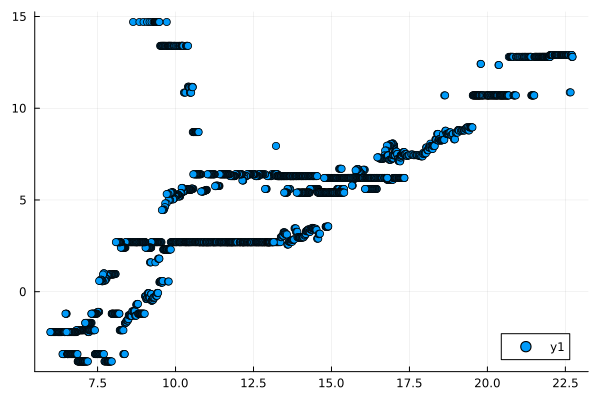

In [24]:
scatter(swdf.latitude, swdf.altitude)

In [25]:
xs = swdf.latitude;
ys = swdf.altitude;

test_x = collect(range(minimum(xs), maximum(xs), length(xs)));

ft = ridge_regression_tanh(xs, ys, 0.0);

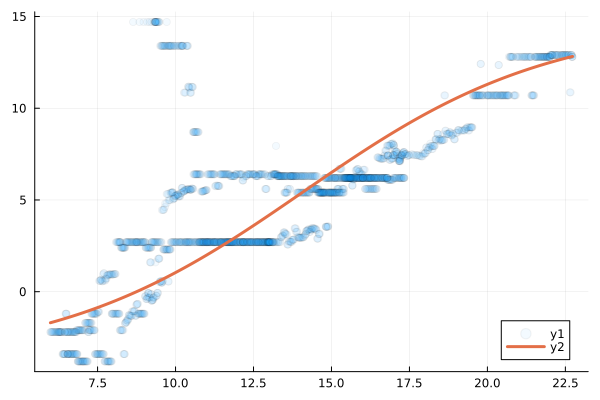

In [27]:
scatter(xs, ys, ma=0.05)
plot!(ft.latitude, ft.altitude, lw=3)

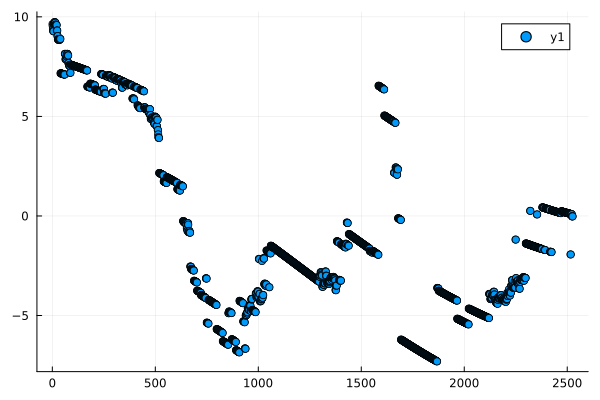

In [28]:
scatter(ft.residuals)

What do I need?

A function that forms a dataframe of residuals
Columns:

|Function|Method|Street|Residuals|Time|
|---|---|---|---|---|


Every function I test should also return residuals as a 


Expo -> $e^x$
tanh -> $tanh(x)$
gompertz -> 


In [29]:
function_ref = get_function_references()

comparison_df = DataFrame(Function=String[], Method=String[], Street=String[], Residuals=[], Time=Float64[])




0×5 DataFrame
 Row │ Function  Method  Street  Residuals  Time    
     │ String    String  String  Any        Float64 
─────┴──────────────────────────────────────────────

In [30]:
# for street in keys(all_dfs)
#      if street != "Museum"
#           dict = Dict()

#           df = scale_coordinates(combine_df_vectors(all_dfs[street]))

#           xs = df.latitude;
#           ys = df.altitude;

#           dict["Function"] = function_ref["expo"];
#           dict["Method"] = "Ridge Regression";
#           dict["Street"] = street;
          
#           ft = ridge_regression_expo(xs, ys, 1.0)
#           time = @elapsed ridge_regression_expo(xs, ys, 1.0)

#           dict["Residuals"] = ft.residuals;
#           dict["Time"] = time

#           push!(comparison_df, dict)
#      end
# end

In [31]:
function add_comparative_data!(comparison_df, all_dfs, method_func, func_parameters, method_name, func_name)
     
     for street in keys(all_dfs)
          if street != "Museum"
               dict = Dict()
     
               df = scale_coordinates(combine_df_vectors(all_dfs[street]))
     
               xs = df.latitude;
               ys = df.altitude;
     
               dict["Function"] = function_ref[func_name];
               dict["Method"] = method_name;
               dict["Street"] = street;
               
               ft = method_func(xs, ys, func_parameters...)
               time = @elapsed method_func(xs, ys, func_parameters...)
     
               dict["Residuals"] = ft.residuals;
               dict["Time"] = time
     
               push!(comparison_df, dict)

               # comparison_df = flatten(comparison_df, :Residuals)
          end
     end
     
end

add_comparative_data! (generic function with 1 method)

In [32]:
add_comparative_data!(comparison_df, all_dfs, ridge_regression_expo,
     [1.0], "Ridge Regression", "expo")




In [33]:
add_comparative_data!(comparison_df, all_dfs, ridge_regression_tanh,
     [1.0], "Ridge Regression", "tanh")

In [34]:
@show comparison_df

comparison_df = 14×5 DataFrame
 Row │ Function     Method            Street       Residuals                          Time
     │ String       String            String       Any                                Float64
─────┼────────────────────────────────────────────────────────────────────────────────────────────
   1 │ $e^x$        Ridge Regression  Newell/West  [3.81325, 3.47958, 3.56426, 3.41…  4.4828e-5
   2 │ $e^x$        Ridge Regression  Gale/West    [0.559249, 0.558476, 0.557702, 0…  0.000249037
   3 │ $e^x$        Ridge Regression  Gale/East    [0.407159, 0.406015, 0.404871, 0…  0.000233731
   4 │ $e^x$        Ridge Regression  Center/West  [0.710626, 0.706971, 1.50331, 0.…  6.1865e-5
   5 │ $e^x$        Ridge Regression  Newell/East  [-1.64525, -1.75523, -1.5742, -1…  5.2311e-5
   6 │ $e^x$        Ridge Regression  Center/East  [1.64042, 1.63727, 1.6341, 1.630…  4.6753e-5
   7 │ $e^x$        Ridge Regression  Sweetwater   [-1.32643, -1.32928, -1.33212, -…  0.000124133
   8 │ 

14×5 DataFrame
 Row │ Function     Method            Street       Residuals                   ⋯
     │ String       String            String       Any                         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ $e^x$        Ridge Regression  Newell/West  [3.81325, 3.47958, 3.56426, ⋯
   2 │ $e^x$        Ridge Regression  Gale/West    [0.559249, 0.558476, 0.5577
   3 │ $e^x$        Ridge Regression  Gale/East    [0.407159, 0.406015, 0.4048
   4 │ $e^x$        Ridge Regression  Center/West  [0.710626, 0.706971, 1.5033
   5 │ $e^x$        Ridge Regression  Newell/East  [-1.64525, -1.75523, -1.574 ⋯
   6 │ $e^x$        Ridge Regression  Center/East  [1.64042, 1.63727, 1.6341,
   7 │ $e^x$        Ridge Regression  Sweetwater   [-1.32643, -1.32928, -1.332
   8 │ $\\tanh(x)$  Ridge Regression  Newell/West  [4.16229, 3.83211, 3.92028,
   9 │ $\\tanh(x)$  Ridge Regression  Gale/West    [0.345556, 0.34542, 0.34528 ⋯
  10 │ $\\tanh(x)$  Ridge Regression  Gale/East    [0.410331, 0.40958, 0.40882
  11 │ $\\tanh(x)$  Ridge Regression  Center/West  [1.58403, 1.58208, 2.38012,
  12 │ $\\tanh(x)$  Ridge Regression  Newell/East  [0.148264, 0.0198172, 0.182
  13 │ $\\tanh(x)$  Ridge Regression  Center/East  [1.66282, 1.66247, 1.66213, ⋯
  14 │ $\\tanh(x)$  Ridge Regression  Sweetwater   [-0.470191, -0.473375, -0.4
                                                               2 columns omitted

In [35]:
temp = comparison_df[in.(comparison_df.Street, Ref(["Center/East"])), :]
# temp = flatten(temp, :Residuals)

2×5 DataFrame
 Row │ Function     Method            Street       Residuals                   ⋯
     │ String       String            String       Any                         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ $e^x$        Ridge Regression  Center/East  [1.64042, 1.63727, 1.6341,  ⋯
   2 │ $\\tanh(x)$  Ridge Regression  Center/East  [1.66282, 1.66247, 1.66213,
                                                               2 columns omitted

In [36]:
@show temp

temp = 2×5 DataFrame
 Row │ Function     Method            Street       Residuals                          Time
     │ String       String            String       Any                                Float64
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │ $e^x$        Ridge Regression  Center/East  [1.64042, 1.63727, 1.6341, 1.630…  4.6753e-5
   2 │ $\\tanh(x)$  Ridge Regression  Center/East  [1.66282, 1.66247, 1.66213, 1.66…  8.4809e-5


2×5 DataFrame
 Row │ Function     Method            Street       Residuals                   ⋯
     │ String       String            String       Any                         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ $e^x$        Ridge Regression  Center/East  [1.64042, 1.63727, 1.6341,  ⋯
   2 │ $\\tanh(x)$  Ridge Regression  Center/East  [1.66282, 1.66247, 1.66213,
                                                               2 columns omitted

ns = 0.5723280358003457
ns = 0.435589798677641


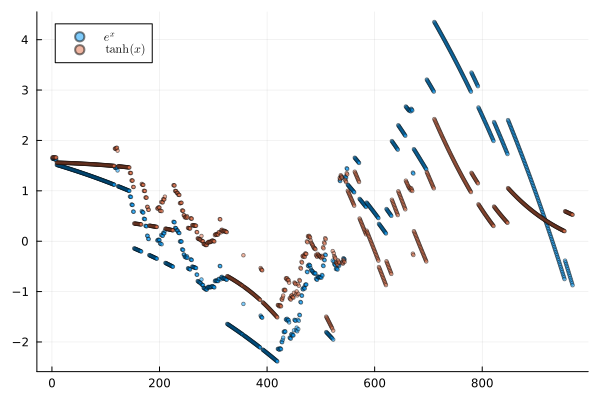

In [37]:
plt = plot()
for r in eachrow(temp)
     ns = mean(r.Residuals)
     @show ns
     scatter!(r.Residuals, label=r.Function, ms=2, ma=0.5)
end
plt

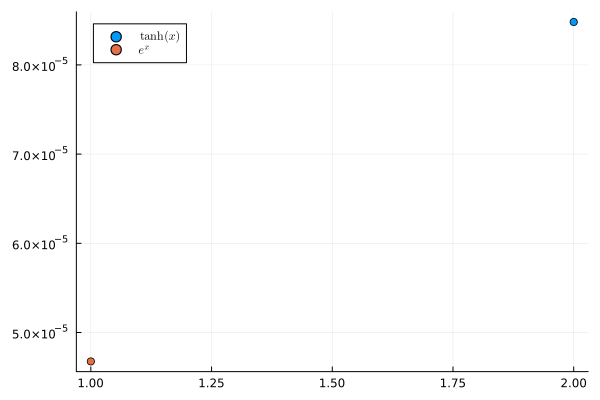

In [38]:
scatter(temp.Time, group=temp.Function)